# Introduction

In this notebook we will develop a timeseries model to predict Day-Ahead electricity prices for the German bidding zone. The input data is taken from the EPEX SPOT energy exchange website and contains all hourly market clearing prices from July 20, 2007 until August 31, 2017. The model will purely feed on this historical timeseries data to extract common temporal patterns of electricity prices.

The output prediction of the model will span all 24 hourly intervals of the next day, using only information that is available prior to Day-Ahead market closing time at 12:00 h of the current day. 

The goal of the model is to predict _general patterns_ of Day-Ahead price movements for the next day. This general pattern might serve as a foundation for a price prediction model that will enhance the general pattern with more detailed information.

## Contents


* [Step 0](#step0): Preprocess the data
* [Step 1](#step1): Set up benchmark models
* [Step 2](#step2): Design the model architecure
* [Step 3](#step3): Finetune the model


In a first step we will explore the dataset and, if necessary, preprocess the data to better fit our prediction model. In order to have a sufficient benchmark for all of hour modeling approaches, we will define a benchmark solution, that serves as a foundation to compare our efforts against. After that, we will design and finetune a neural network to predict prices on the Day-Ahead market.

---

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import timeseries as ts
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.externals import joblib
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [2]:
# load the historical Day-Ahead price data
da_raw = pd.read_csv('./raw_data/EPEX_spot_DA_auction_hour_prices_20070720-20170831.csv',
                     index_col=0, parse_dates=True)
da_raw.head(n=5)

,DA_price
2007-07-20 00:00:00,25.69
2007-07-20 01:00:00,26.45
2007-07-20 02:00:00,24.33
2007-07-20 03:00:00,23.57
2007-07-20 04:00:00,18.96


In [3]:
len(da_raw)

88704

<a id='step0'></a>
# Preprocess the data

In [4]:
# check if their are any gaps within the data
any(da_raw.dropna().index.to_series().diff() > pd.Timedelta('01:00:00'))

False

In [5]:
da_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
DA_price,88704.0,41.295654,21.352333,-500.02,29.0,38.64,50.97,821.9


**Analysis**

While the majority of the price data seems lies within a price range of 20-50 €/MWh, the maximum and minimum prices of 822 €/MWh and -500 €/MWh constitute significant outliers. Since we are mainly interested in figuring out a _general temporal pattern_, these outliers are really undesirable. Moreover, they will screw up each attempt of min-max scaling the data. The outliers will determine the 0- and 1-equivalents of the new scale while most of the data corpus will lie within a very small range without much variation in between 'common' samples as a result. 

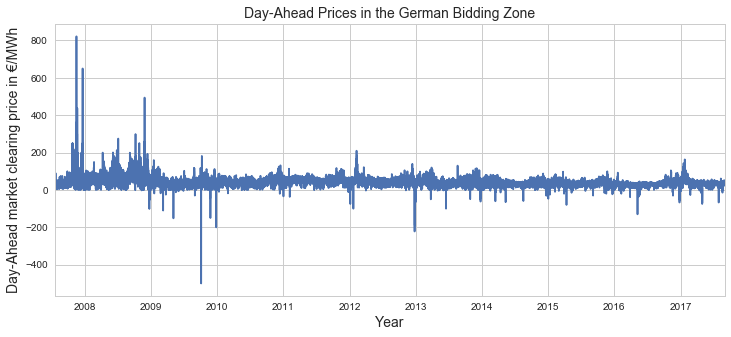

In [7]:
# plot the price full price data set
ax = da_raw.plot(figsize=(12, 5), legend=False)
ax.set_ylabel('Day-Ahead market clearing price in €/MWh', fontsize=14)
ax.set_title('Day-Ahead Prices in the German Bidding Zone', fontsize=14)
ax.set_xlabel('Year', fontsize=14);
# plt.savefig('./img/DA_prices_all.eps' , format='eps', dpi=1000, bbox_inches='tight');

__Analysis__

We can see that there are extreme price peaks in late 2007 and extreme price lows in late 2009. These price peaks are most likely due to market flaws in the early days of Day-Ahead trading. We can see that the price range gets substantially smaller in the more recent years. These extreme prices should be removed to avoid problems when scaling the data to a range between 0 and 1. Scaling will be essential for our purposes, since we plan on using a neural network for this task. Neural networks generally benefit from feature scaling.

---
Before actually preprocessing the data, we will have a quick look at the general distribution of the data, especially with respect to any patterns that are identifiable with pure visualization. First, we will plot the average price for all months, weekdays and hours.

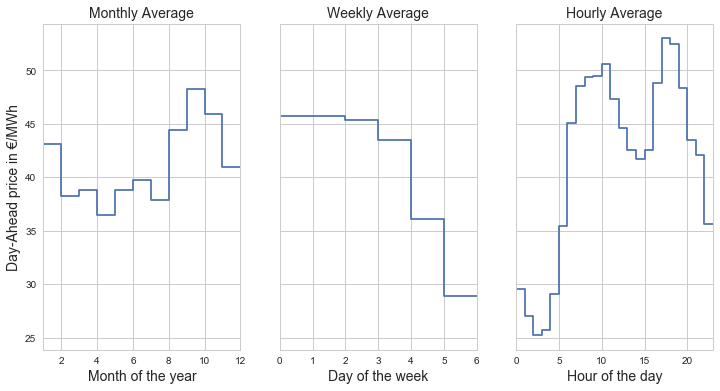

In [9]:
# aggregate and average dat with respect to filter criterion and plot results
ts.plot_average_prices(da_raw);

__Analysis__

We can see that electricity price data shows some very obvious temporal patterns. Electricity is cheaper in summer than in winter. While electricity costs most during workdays, it drops towards the weekend with lowest prices on Sunday. Over the course of a day, electricity is cheapest after midnight, peaks in the morning and evening hours and is a little lower during working hours. Those are very superficial analyses of temporal patterns, but it is obvious that there are some patterns available, that we should be able to extract from the data.

---

In the next steps, we will preprocess the data for training. Since we need real, unprocessed data as a sufficient baseline for evaluating the model performance, we will keep an untouched copy of data (all prices of 2017) as a test set for evaluation purposes

In [10]:
# keep raw data of the test set for model evaluation
test_raw = da_raw['2017']




## Remove outliers

As shown above, our data includes some significant outliers that might be detrimental for our intentions. We will apply a quite aggressive outlier removal and replace values that are outside the 3 x interquartile range of the 25% and 75% quantiles with the respective quantiles. 

In [11]:
# replace outliers by outlier threshold
da_prep = ts.replace_outliers(da_raw, 'DA_price', 3)

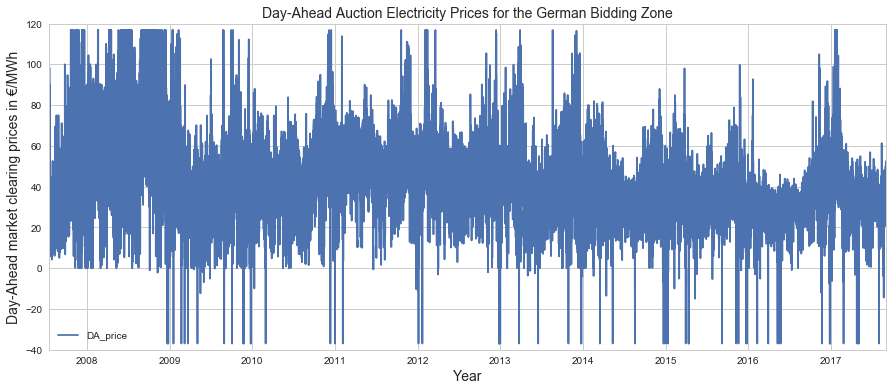

In [12]:
# plot the results
ax = da_prep.plot(figsize=(15, 6))
ax.set_ylabel('Day-Ahead market clearing prices in €/MWh', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.set_title('Day-Ahead Auction Electricity Prices for the German Bidding Zone', fontsize=14)
ax.set_ylim((-40, 120));

__Analysis__

The range of the prices now looks much more appropriate to be scaled to 0-1 values. When scaling, the data will now be much more spread out instead of concentrating around some median value, as it would have been the case when the outliers would not have been removed. The histogram below shows the distribution of prices for which outliers have been replaced.

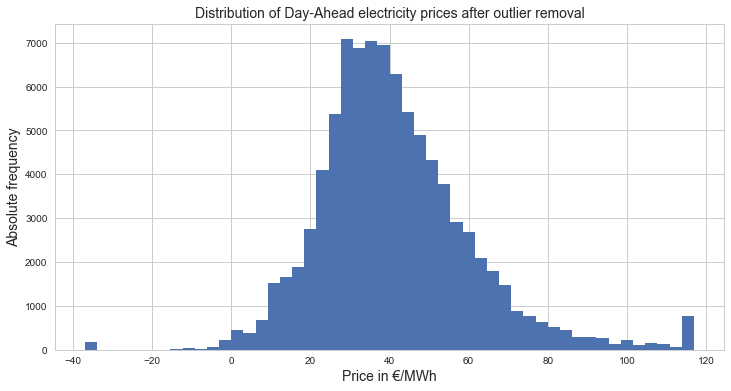

In [13]:
f, ax = plt.subplots(figsize=(12, 6))
da_prep.hist(bins=50, ax=ax)
ax.set_title('Distribution of Day-Ahead electricity prices after outlier removal', fontsize=14)
ax.set_ylabel('Absolute frequency', fontsize=14)
ax.set_xlabel('Price in €/MWh', fontsize=14);

## Scaling and rearranging the data

We use a sklearn.MinMaxScaler to scale the data to a range of 0-1

In [14]:
# scale data to range between 0 and 1
da_scaler = MinMaxScaler()
da_prep['DA_price'] = da_scaler.fit_transform(da_prep['DA_price'].values.reshape(-1, 1))

__Explanation__

Our model will be fed with historical timeseries data. In order to predict the next 24 hours of a single day, it will require historical price values for the last $n$ hours prior to this day. This logic has to be represented by the strucutre of the data we feed into the model. For a better intuitive understanding, see the figure below. The blue part of the data will serve as input, a set of features, for predicting the red part of the line. The input is a vector of historical prices, the output a vector of prices for the upcoming day, one entry per hour.

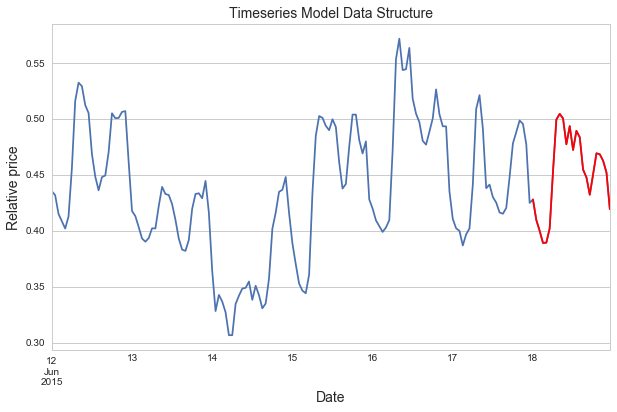

In [15]:
feature_data = da_prep.loc['2015-06-12':'2015-06-18', 'DA_price']
feature_data.columns = ['input data']
label_data = da_prep.loc['2015-06-18', 'DA_price']
label_data.columns = ['data to predict']
f, ax = plt.subplots(figsize=(10, 6))
feature_data.plot(ax=ax)
label_data.plot(ax=ax, color='red')
ax.set_ylabel('Relative price', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('Timeseries Model Data Structure', fontsize=14);

In order to achieve that structure the data has to be 'lagged'. This can be achieved by adding columns to every row of the input data, one column for each lagged value. In order to use the last week hourly price data, we have to lag for 7x24=168 hours. 

In [16]:
# include time lags of timeseries data for 1 week = 7 * 24h = 168h
lags = 168
for l in range(1, lags+1):
    da_prep['l_{}'.format(l)] = da_prep['DA_price'].shift(l)

In [17]:
# drop missing data entries that result from the lagging step (no lagged data available for first 168 days of year)
da_prep.dropna(inplace=True)
da_prep.head(n=5)

,DA_price,l_1,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,...,l_159,l_160,l_161,l_162,l_163,l_164,l_165,l_166,l_167,l_168
2007-07-27 00:00:00,0.388972,0.390402,0.435139,0.409454,0.421354,0.429027,0.435529,0.432083,0.454516,0.455231,...,0.591716,0.558164,0.468236,0.425450,0.406984,0.363288,0.393264,0.398205,0.411990,0.407049
2007-07-27 01:00:00,0.369920,0.388972,0.390402,0.435139,0.409454,0.421354,0.429027,0.435529,0.432083,0.454516,...,0.858053,0.591716,0.558164,0.468236,0.425450,0.406984,0.363288,0.393264,0.398205,0.411990
2007-07-27 02:00:00,0.343325,0.369920,0.388972,0.390402,0.435139,0.409454,0.421354,0.429027,0.435529,0.432083,...,0.880031,0.858053,0.591716,0.558164,0.468236,0.425450,0.406984,0.363288,0.393264,0.398205
2007-07-27 03:00:00,0.330451,0.343325,0.369920,0.388972,0.390402,0.435139,0.409454,0.421354,0.429027,0.435529,...,0.760518,0.880031,0.858053,0.591716,0.558164,0.468236,0.425450,0.406984,0.363288,0.393264
2007-07-27 04:00:00,0.300800,0.330451,0.343325,0.369920,0.388972,0.390402,0.435139,0.409454,0.421354,0.429027,...,0.578711,0.760518,0.880031,0.858053,0.591716,0.558164,0.468236,0.425450,0.406984,0.363288


**Explanation**

One sample, representing one hour, now contains the true price for that hour as well as hourly prices of the last 168 hours prior to that hour. 

Since we want to predict for all hours of a full day _at once_, he lagged data has to be split into chunks of 24 hours in order for a feature-label combination to represent a full day. A sample output ('label') will be a vector of length 24, one entry for each hour of the prediction day. The sample features will be a vector of length 168, one entry for every lagged hour of the prior week. 

We will use all data prior to 2017 as training data and all data from 2017 as test data. We do not pick test samples randomly, since we are interested in the performance of our model on the most recent data.

Then, the input to the model is a feature tensor of shape (samples, lags, features) and the output a tensor of shape (samples, hours_of_next_day). Note that we only have one kind of feature, the historical prices.

In [18]:
# create feature and label dataframes
prelim_features = da_prep.drop('DA_price', axis=1)
prelim_labels = pd.DataFrame(da_prep['DA_price'])

# format labels to 24 hour output range
for i in range(0, 24):
    prelim_labels['t_{}'.format(i)] = prelim_labels['DA_price'].shift(-i)
prelim_labels.drop('DA_price', axis=1, inplace=True)

# apply one-day discretization to the data
labels = prelim_labels[prelim_labels.index.hour == 0]
features = prelim_features[prelim_features.index.hour == 0]

features_train = features[:'2016']
features_test = features['2017':]
labels_train = labels[:'2016']

samples_train = len(features_train)
samples_test = len(features_test)
timesteps = 168

# convert pandas data frames to numpy ndarrays
features_train = features_train.as_matrix().reshape(samples_train, timesteps, 1)
features_test = features_test.as_matrix().reshape(samples_test, timesteps, 1)
labels_train = labels_train.as_matrix()

# check for correct data shape
features_train.shape, labels_train.shape

((3446, 168, 1), (3446, 24))

Now that we have organized and preprocessed the data for our task, we split it into a training and a validation set. The validation set will serve as pseudo-unseen data for model for parameter selection during the training process. The final evaluation however will be conducted with the truly unseen test set that has remained untouched.

<a id='step1'></a>
# Set up the benchmark model

In [19]:
from keras.models import Model, load_model
from keras.layers import Input, Add
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import json

Using TensorFlow backend.


A benchmark model has to be set up in order to evaluate how well we are performing with the different modeling approaches. This benchmark model has to be some kind of 'best guess' that one could expect to be able to make without much modeling effort. In this case simple averages of reference points are used as benchmarks. In total four naive benchmarks are used here:
1. The price of the same hour the day before as a prediction.
2. The price of the same hour of the same day the week before as a prediction.
3. The average of the same hour of every day during the last two weeks as a prediction.
4. The average of the same hour of every day during the last four weeks as a prediction.

The primary goal for the timeseries model is to beat these benchmark results by a fair margin. The test set is used as actual benchmarking data.

In [20]:
# calculate benchmarks for test set and save them to dataframe
benchmark_results = pd.DataFrame(index=test_raw.index)

benchmark_results['last_day'] = da_raw.shift(24)['2017']
benchmark_results['last_week'] = da_raw.shift(24*7)['2017']
benchmark_results['2_week_average'] = pd.concat([da_raw.shift(24 * w) for w in range(1, 3)], axis=1).mean(axis=1)['2017']
benchmark_results['4_week_average'] = pd.concat([da_raw.shift(24 * w) for w in range(1, 5)], axis=1).mean(axis=1)['2017']

In [21]:
# calculate mean absolute errors for benchmark models
for col in benchmark_results.columns:
    pred = benchmark_results[col].as_matrix()
    true = test_raw.DA_price.as_matrix()
    print('MAE of {} benchmark model: '.format(col), mean_absolute_error(y_pred=pred, y_true=true))

MAE of last_day benchmark model:  8.5257441701
MAE of last_week benchmark model:  9.13819101509
MAE of 2_week_average benchmark model:  8.97544495885
MAE of 4_week_average benchmark model:  9.17504458162


**Analysis**

We can see that on average the benchmark model misses the true prices of the next day by roughly 9€ per MWh. This is not too bad of an estimation, but we certainly can get better than this.

<a id='step2'></a>
# Design the model architecture

Before training a model, the data is split into a training and a validation set. The validation set serves as a model selection criterion during training. Since a good performance on a training set might as well result from overfitting the model, a validation set is needed as a first estimation about the ability of the model to generalize.

In [22]:
# split into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(features_train, labels_train, test_size=0.2, random_state=7)

In [23]:
def train_predict_evaluate(model, X_train, X_valid, y_train, y_valid, X_test, y_test, test_index, scaler, 
                           batch_size, epochs, filename='model.hdf5', verbose=0):
    
    """Fit model to training data. Use best performant on validation data to predict for the test set. 
    Evaluate on the test set and return results as dataframes"""
    
    # train model, save best keep best performer on validation set
    checkpoint = ModelCheckpoint('./models/' + filename, save_best_only=True)
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[checkpoint], 
                     verbose=verbose, batch_size=batch_size, epochs=epochs)
    
    # load best model
    best = load_model('./models/' + filename)

    # predict for test set
    pred = best.predict(X_test)
    
    
    # transform back to original data scale
    pred = scaler.inverse_transform(pred.flatten().reshape(-1, 1))
    results = pd.DataFrame({'prediction':pred.flatten(), 'true values':y_test}, index=test_index)
    
    return results, hist

## First model architecture

The modeling approach below makes use of convolutional and recurrent neural networks. For an excellent and comprehensive introduction into convolutional and recurrent neural networks, especially LSTM cells, see these blog post:

* http://colah.github.io/posts/2014-07-Conv-Nets-Modular/
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/


The first model approach is a hybrid neural network with a one-dimensional convolutional layer, a recurrent layer of Long Short Term Memory (LSTM) cells and a densely connected layer. The dense layer serves as the output layer. Its size is fixed to 24 cells, one for each hour of the day to predict prices for. 

The idea behind the combination of the convolutional and the recurrent layer is to cover short- _and_ long-term patterns in the data. The convolutional layer has a kernel size and a stride of 24. Hence, in one convolutional step 24 hours of historical data will be covered. This results in an convolutional output of length 7 per feature map, which spans exactly the one week of historical data we covered as an input. Each entry in this vector is a representation of all prices (aggregated by the weights in the filter) of one single day within the range of input features. 

The LSTM cells in the recurrent layer are able to 'memorize' previous information. The output of a LSTM cell not only depends on its current input, but also on inputs received in previous sequence entries. In our case, the sequence is the output of the convolutional layer, containing 7 whole-day representation per feature map in the convolutional layer. The LSTM might use these 7 entries to infer a long term trend from the data. As we have seen, electricity prices follow a clear weekly pattern. Referencing a sequence of 7 days spans a whole week of data. Thus, the LSTM layer should be able to 'realize' the current weekday due to its ability to memorize outputs in previous sequence entries. 

The reason we do not feed all 168 timesteps to the LSTM layer is quite simple: Feature dimensionality. 168 features are quite hard for a LSTM to 'keep in memory' due to the sheer size of the feature space.

The dimensions for the different layers are picked rather randomly after a few trials and errors of what works and what not.

> **Note:** If you rerun the training code, expect different results to those displayed in this prerun version of the notebook. This is mainly caused by randomness in the training process that leads to different results when rerunning the code.

In [24]:
# design the neural network architecture with the keras functional API
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Conv1D(64, kernel_size=24, strides=24, padding='valid')(input_layer)
x = LSTM(32, recurrent_activation='relu')(x)
output_layer = Dense(24)(x)
model = Model(inputs=[input_layer], outputs=[output_layer])
model.compile(loss='mse', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 168, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 7, 64)             1600      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 24)                792       
Total params: 14,808
Trainable params: 14,808
Non-trainable params: 0
_________________________________________________________________


In [22]:
# train the model and calculate the performance on the test set
results, hist = train_predict_evaluate(model, X_train, X_valid, y_train, y_valid, features_test,
                                       test_raw.as_matrix().flatten(), test_raw.index, da_scaler, 50, 200, 
                                       'simple_neural_network.hdf5', verbose=1)

Train on 2756 samples, validate on 690 samples
Epoch 1/200
2756/2756 [==============================] - 1s - loss: 0.1322 - val_loss: 0.0208
Epoch 2/200
2756/2756 [==============================] - 0s - loss: 0.0099 - val_loss: 0.0067
Epoch 3/200
2756/2756 [==============================] - 0s - loss: 0.0065 - val_loss: 0.0066
Epoch 4/200
2756/2756 [==============================] - 0s - loss: 0.0066 - val_loss: 0.0065
Epoch 5/200
2756/2756 [==============================] - 0s - loss: 0.0063 - val_loss: 0.0064
Epoch 6/200
2756/2756 [==============================] - 0s - loss: 0.0063 - val_loss: 0.0062
Epoch 7/200
2756/2756 [==============================] - 0s - loss: 0.0061 - val_loss: 0.0062
Epoch 8/200
2756/2756 [==============================] - 0s - loss: 0.0059 - val_loss: 0.0060
Epoch 9/200
2756/2756 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0058
Epoch 10/200
2756/2756 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0058
Epoch 11/200

2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0034
Epoch 172/200
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0034
Epoch 173/200
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0031
Epoch 174/200
2756/2756 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0033
Epoch 175/200
2756/2756 [==============================] - 1s - loss: 0.0031 - val_loss: 0.0031
Epoch 176/200
2756/2756 [==============================] - 1s - loss: 0.0030 - val_loss: 0.0032
Epoch 177/200
2756/2756 [==============================] - 1s - loss: 0.0031 - val_loss: 0.0032
Epoch 178/200
2756/2756 [==============================] - 1s - loss: 0.0030 - val_loss: 0.0037
Epoch 179/200
2756/2756 [==============================] - 1s - loss: 0.0033 - val_loss: 0.0034
Epoch 180/200
2756/2756 [==============================] - 1s - loss: 0.0032 - val_loss: 0.0031
Epoch 181/200
2756/2756 [=============================

In [25]:
print('MAE: ', mean_absolute_error(y_pred=results['prediction'], y_true=results['true values']))

MAE:  5.89306166437


**Analysis**

The performance of this first model is clearly superior to the benchmark results, beating the best benchmark mean absolute error by about 3€ per MWh. Next, we will explore what an abstract error metrics means visually.

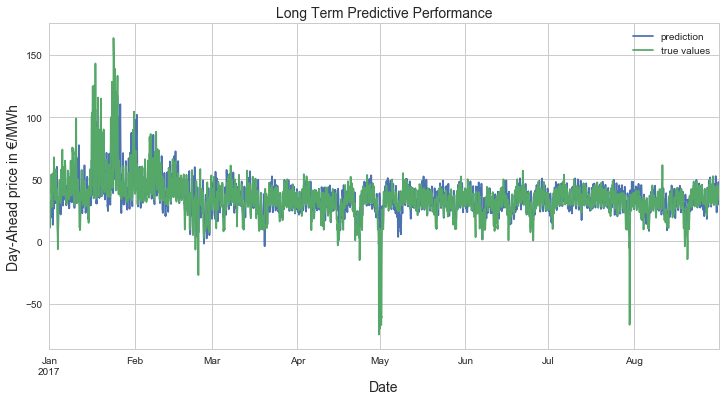

In [27]:
f, ax = plt.subplots(figsize=(12, 6))
results.plot(ax=ax)
ax.set_ylabel('Day-Ahead price in €/MWh', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('Long Term Predictive Performance', fontsize=14);

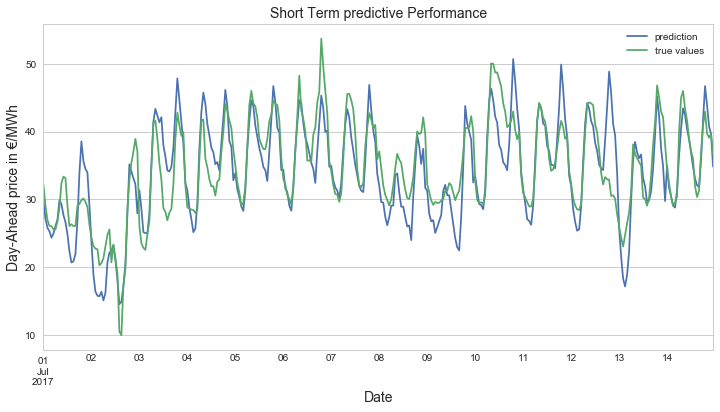

In [30]:
f, ax = plt.subplots(figsize=(12, 6))
results.loc['2017-07':'2017-07-14'].plot(ax=ax);
ax.set_ylabel('Day-Ahead price in €/MWh', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('Short Term predictive Performance', fontsize=14);

**Analysis**

The figures above show, that the model performs quite well in covering long term trends (high, volatile price levels in winter vs lower prices in summer), the weekly seasonality of work days vs weekends, and the daily pattern of price movements. Extreme values, like price peaks, are not covered very well by the model. This is not surprising, since we initially cut off outliers from the data. Apart from that, there are some major errors over the course of single days. In total, the model does a pretty good job in predicting a general temporal pattern in the price data. In order to successfully cover short term deviations and 'unusual' price developments, we most certainly have to add more and different data. We will cover this step in a different part of this project

For now, we will focus on finetuning the timeseries model. In the figure below, the development of the training and the validation loss is plotted. Both values oscillate significantly. We can also see that the training loss gets smaller than the validation loss and keeps on improving over time, while the validation loss stagnates. This is a sign of overfitting. The model is fitted too closely to the training data, additional training epochs do not improve the ability of the model to generalize anymore. We have to keep that issue in mind for the next steps.

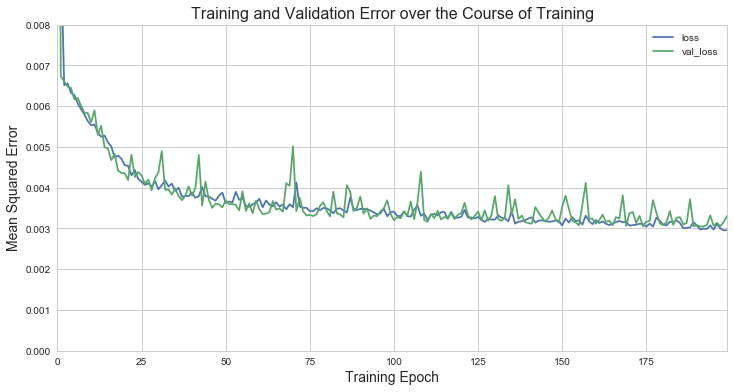

In [32]:
f, ax = plt.subplots()
pd.DataFrame(hist.history).plot(figsize=(12, 6), ax=ax)
ax.set_ylim([0, 0.008])
ax.set_title('Training and Validation Error over the Course of Training', fontsize=16)
ax.set_ylabel('Mean Squared Error', fontsize=14)
ax.set_xlabel('Training Epoch', fontsize=14);

## Trying different architectures

Below, we will try out different layer sizes for our model. We vary the size of the convolutional layer and the LSTM layer to see if we can find a better architecure. 

> **Note:** Training a model always contains a significant amount of randomness (e.g. in the initialization of the model weights). If a certain model yields better results than another approach, it is possible that this success is based on a 'lucky' hit, rather than general superior performance. The tests below should be viewed with caution. As long as there is no **substantial** performance improvement in one architecture over the others, there is no reason to discard a certain architecture based on a single training iteration. We will address this problem in a grid search approach in a later step.

In [100]:
def create_model(nodes):
    
    """Create default model architecture with input node sizes."""
    
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = Conv1D(nodes[0], kernel_size=24, strides=24, padding='valid')(input_layer)
    x = LSTM(nodes[1], recurrent_activation='relu')(x)
    output_layer = Dense(24)(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(loss='mse', optimizer='adam')
    
    return model

In [109]:
archs = []

##### Smaller Convolutional layer

In [110]:
archs.append(create_model([32, 32]))

##### Smaller Recurrent layer

In [111]:
archs.append(create_model([64, 16]))

##### Smaller Convolutional and Recurrent layer

In [112]:
archs.append(create_model([32, 16]))

##### Bigger Convolutional layer

In [113]:
archs.append(create_model([128, 32]))

##### Bigger Recurrent layer

In [114]:
archs.append(create_model([64, 64]))

##### Bigger Convolutional and Recurrent Layer

In [115]:
archs.append(create_model([128, 64]))

In [116]:
# train all archtitectures and evaluate performance on the test set
for i, model in enumerate(archs):

    results, hist = train_predict_evaluate(model, X_train, X_valid, y_train, y_valid, features_test,
                                       test_raw.as_matrix().flatten(), test_raw.index, da_scaler, 50, 200, 
                                       'timeseries_architecture_tests.hdf5', verbose=0)
    
    mae = mean_absolute_error(y_pred=results['prediction'], y_true=results['true values']
    print('MAE of model {}: '.format(i), mae)

MAE of model 0:  6.13284756291
MAE of model 1:  6.186185299
MAE of model 2:  6.04607621733
MAE of model 3:  5.97047192907
MAE of model 4:  5.75450460948
MAE of model 5:  5.64987142394


#### Adding a linear bypass

A recent paper [1] on timeseries prediction with neural networks proposes to add an additional linear bypass to the model. This bypass might be able to capture volatility in recent prices better than the combination of convolutional and recurrent layers. the linear bypass used here consists of a simple dense layer with 64 nodes, connecting to an additional output layer. The two output layers are added element wise to produce the total output of the model. The linear bypass feeds on the same data as the convolutional layer. We just have to adjust the input vector shape a little bit.

[1] https://arxiv.org/abs/1703.07015

In [83]:
conv_input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# additional input layer for the linear bypass
lin_input_layer = Input(shape=(X_train.shape[1],))

x = Conv1D(64, kernel_size=24, strides=24, padding='valid')(conv_input_layer)
x = LSTM(32, recurrent_activation='relu')(x)
x = Dense(24)(x)

# linear bypass
y = Dense(64)(lin_input_layer)
y = Dense(24)(y)

# add outputs of both model 'branches' together
add = Add()([x, y])

model = Model(inputs=[conv_input_layer, lin_input_layer], outputs=[add])
model.compile(loss='mse', optimizer='adam')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_13 (InputLayer)            (None, 168, 1)        0                                            
____________________________________________________________________________________________________
conv1d_8 (Conv1D)                (None, 7, 64)         1600        input_13[0][0]                   
____________________________________________________________________________________________________
input_14 (InputLayer)            (None, 168)           0                                            
____________________________________________________________________________________________________
lstm_8 (LSTM)                    (None, 32)            12416       conv1d_8[0][0]                   
___________________________________________________________________________________________

In [84]:
# squeeze feature tensors to have shape (samples, timesteps) for linear input layer
X_train_multi = [X_train, X_train.squeeze()]
X_valid_multi = [X_valid, X_valid.squeeze()]
features_test_multi = [features_test, features_test.squeeze()]

# run model with both input vectors at the same time
results, hist = train_predict_evaluate(model, X_train_multi, X_valid_multi, y_train, y_valid, features_test_multi,
                                       test_raw.as_matrix().flatten(), test_raw.index, da_scaler, 50, 200, 
                                       'timeseries_linear_bypass.hdf5', verbose=1)

Train on 2756 samples, validate on 690 samples
Epoch 1/200
2756/2756 [==============================] - 2s - loss: 0.0732 - val_loss: 0.0164
Epoch 2/200
2756/2756 [==============================] - 0s - loss: 0.0132 - val_loss: 0.0115
Epoch 3/200
2756/2756 [==============================] - 0s - loss: 0.0102 - val_loss: 0.0096
Epoch 4/200
2756/2756 [==============================] - 0s - loss: 0.0086 - val_loss: 0.0084
Epoch 5/200
2756/2756 [==============================] - 0s - loss: 0.0077 - val_loss: 0.0078
Epoch 6/200
2756/2756 [==============================] - 0s - loss: 0.0073 - val_loss: 0.0067
Epoch 7/200
2756/2756 [==============================] - 0s - loss: 0.0065 - val_loss: 0.0065
Epoch 8/200
2756/2756 [==============================] - 0s - loss: 0.0061 - val_loss: 0.0060
Epoch 9/200
2756/2756 [==============================] - 0s - loss: 0.0058 - val_loss: 0.0059
Epoch 10/200
2756/2756 [==============================] - 0s - loss: 0.0056 - val_loss: 0.0056
Epoch 11/200

2756/2756 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0029
Epoch 172/200
2756/2756 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0032
Epoch 173/200
2756/2756 [==============================] - 0s - loss: 0.0027 - val_loss: 0.0029
Epoch 174/200
2756/2756 [==============================] - 0s - loss: 0.0027 - val_loss: 0.0028
Epoch 175/200
2756/2756 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0031
Epoch 176/200
2756/2756 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0032
Epoch 177/200
2756/2756 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0028
Epoch 178/200
2756/2756 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0028
Epoch 179/200
2756/2756 [==============================] - 0s - loss: 0.0026 - val_loss: 0.0038
Epoch 180/200
2756/2756 [==============================] - 0s - loss: 0.0027 - val_loss: 0.0029
Epoch 181/200
2756/2756 [=============================

In [85]:
mae = mean_absolute_error(y_pred=results['prediction'], y_true=results['true values']
print('MAE: ', mae)

MAE {}:  5.78299094523


**Analysis**

None of these models has been able to outperform the orignal model by a significant margin. The question on which model and parametrization to choose can only be answered by running many different training iterations on different subsets of inputs and outputs to find the best average performance. Since computational resources and time are quite limited in this project, we will go ahead with the linear bypass model. We will see in further steps, that tweaking and finetuning that model will lead to better results in general. 

<a id='step3'></a>
# Finetuning the model

In order to find the best parametrization, a grid search cross validation including a variety of different parameters is performed. We will add dropout layers and different activation functions to the model. Apart from that, we introduce l1/l2 regularization, also known as elastic net regularization, to the linear bypass. The grid search tests all of the predefined parameter combinations against each other by performing a ten-fold cross validation over each combination. The decision on which parametrization to pick is based on the best average performance of the respective parametrization over all folding iterations. 

sklearn GridSearchCV does not work with multi-input models, as stated in https://github.com/fchollet/keras/issues/6451
Hence, we will implement our own grid search routine to test all these parameteres together with the keras checkpoint functionality. 

In [1]:
from sklearn.model_selection import ShuffleSplit, ParameterGrid
from sklearn.metrics import mean_squared_error

In [3]:
# define the parameter grid
grid = {'optimizer': ['adam'],
                  'loss': ['mse'],
                  'batch_size': [50],
                  'dropout': [0.1, 0.2],
                  'l1_l2': [0, 0.01, 0.02],
                  'recurrent_activation': ['linear', 'relu'],
                  'conv_activation' : ['linear', 'relu']}

# combine all parameter variations
parameter_grid = ParameterGrid(grid)

total = len(parameter_grid)

> **Careful: ** The step below will take around 24-36 hours to finish. Results will be provided with this notebook for reference.

In [ ]:
results = {}

# iterate over all parameter combinations, train the model on 10 random subsets and save results
for i, params in enumerate(parameter_grid):
    print('training {} out of {} parameter configurations'.format(i + 1, total))
    param_results = {}
    splits = ShuffleSplit(n_splits=10, test_size=0.2, random_state=7).split(features_train, labels_train)
    
    for n, (train_indices, valid_indices) in enumerate(splits):
        print('   split {} training'.format(n))
        X_train = features_train[train_indices]
        X_valid = features_train[valid_indices]
        y_train = labels_train[train_indices]
        y_valid = labels_train[valid_indices]
        
        X_train_multi = [X_train, X_train.squeeze()]
        X_valid_multi = [X_valid, X_valid.squeeze()]
        features_test_multi = [features_test, features_test.squeeze()]
        
        conv_input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
        lin_input_layer = Input(shape=(X_train.shape[1],))

        x = Conv1D(64, kernel_size=24, strides=24, padding='valid', activation=params['conv_activation'])(conv_input_layer)
        x = Dropout(params['dropout'])(x)
        x = LSTM(32, recurrent_activation=params['recurrent_activation'])(x)
        x = Dropout(params['dropout'])(x)
        x = Dense(24)(x)

        y = Dense(64, kernel_regularizer=l1_l2(params['l1_l2']))(lin_input_layer)
        y = Dropout(params['dropout'])(y)
        y = Dense(24)(y)

        add = Add()([x, y])

        model = Model(inputs=[conv_input_layer, lin_input_layer], outputs=[add])
        model.compile(loss=params['loss'], optimizer=params['optimizer'])

        results, hist = train_predict_evaluate(model, X_train_multi, X_valid_multi, y_train, y_valid,
                                               features_test_multi, test_raw.as_matrix().flatten(),
                                               test_raw.index, da_scaler, 50, 200,
                                               'timeseries_grid_search.hdf5', verbose=0)

        mse = mean_squared_error(y_pred=results.pred, y_true=results.true)
        mae = mean_absolute_error(y_pred=results.pred, y_true=results.true)

        param_results['split{}'.format(n)] = {'mae':mae, 'mse':mse}
        
        print('done')

    mae_avg = np.mean([param_results[key]['mae'] for key in param_results.keys()])
    mse_avg = np.mean([param_results[key]['mse'] for key in param_results.keys()])

    results[str(params)] = {'splits':param_results, 'mae_avg':mae_avg, 'mse_avg':mse_avg}
    
    with open('./timeseries_gridsearch_results.json', 'w') as fp:
        json.dump(results, fp)

In [15]:
with open('./timeseries_gridsearch_results.json') as f:
    final_results = json.load(f)

**Analysis**

The grid search cross validation results can be used to pick a parametrization that performs best on average. Please note that not all interesting parameters have been tested in this grid search. There are a lot more combinations worth trying, but in the end these experiments cost a lot of computation time. We will go further with the best parametrization found in this particular parameter grid.  

In [55]:
# extract mean performance metrics for every parameter combination
mae_avg = dict([(key, value['mae_avg']) for key, value in final_results.items()])
mse_avg = dict([(key, value['mse_avg']) for key, value in final_results.items()])

In [56]:
# find best performing parametrization
best_mae = min(mae_avg, key=mae_avg.get)
best_mse = min(mse_avg, key=mse_avg.get)

In [57]:
best_mse

"{'batch_size': 50, 'conv_activation': 'linear', 'dropout': 0.1, 'l1_l2': 0.01, 'loss': 'mse', 'optimizer': 'adam', 'recurrent_activation': 'relu'}"

In [58]:
best_mae

"{'batch_size': 50, 'conv_activation': 'linear', 'dropout': 0.1, 'l1_l2': 0.01, 'loss': 'mse', 'optimizer': 'adam', 'recurrent_activation': 'relu'}"

**Analysis**

The above parametrization has proven to perform best on average. We use this parametrization to produce our final results. 


## Training the final model

The final model is trained one last time.

In [89]:
X_train_multi = [X_train, X_train.squeeze()]
X_valid_multi = [X_valid, X_valid.squeeze()]
features_test_multi = [features_test, features_test.squeeze()]

conv_input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lin_input_layer = Input(shape=(X_train.shape[1],))

x = Conv1D(64, kernel_size=24, strides=24, padding='valid', activation='linear')(conv_input_layer)
x = Dropout(0.1)(x)
x = LSTM(32, recurrent_activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(24)(x)
y = Dense(64, kernel_regularizer=l1_l2(0.01))(lin_input_layer)
y = Dropout(0.1)(y)
y = Dense(24)(y)

add = Add()([x, y])

model = Model(inputs=[conv_input_layer, lin_input_layer], outputs=[add])
model.compile(loss='mse', optimizer='adam')

results, hist = train_predict_evaluate(model, X_train_multi, X_valid_multi, y_train, y_valid,
                                       features_test_multi, test_raw.as_matrix().flatten(),
                                       test_raw.index, da_scaler, 50, 200,
                                       'timeseries_final_model.hdf5', verbose=0)


In [42]:
print('MAE: ', mean_absolute_error(y_pred=results['prediction'], y_true=results['true values'])

5.4793681985548659

**Analysis**

As we can see, the final mean absolute error on the test set has improved quite a bit when compared to the intitial, untuned model. The figure below shows training and validation error over the course of the training epochs. In contrast to earlier models, the curve is much smoother, there are way less oscillations. This is a good sign for the overall stability of our model. The predictive power now does not vary that much in between epochs anymore. Predictions on unseen data should be much more stable and not dependent on hitting a 'good' training epoch. 

This final model is used to create bottleneck features as inputs for other models.

(0, 0.05)

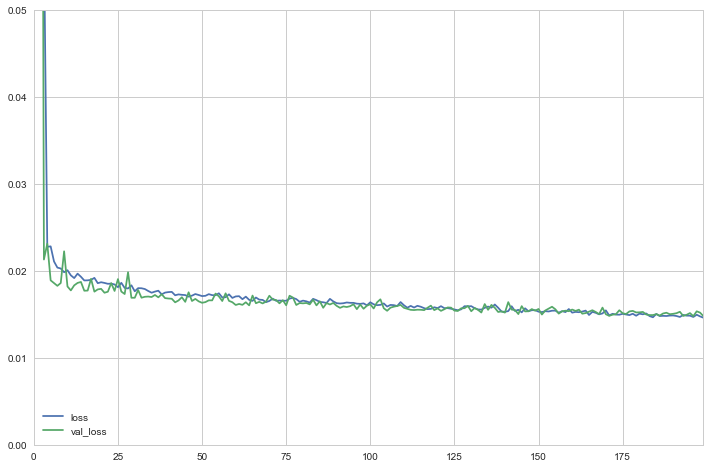

In [40]:
f, ax = plt.subplots()
pd.DataFrame(hist.history).plot(figsize=(12, 8), ax=ax)
ax.set_ylim([0, 0.05])

In [51]:
# run model on all available samples to create bottleneck features
bottleneck_features_train = model.predict([features_train, features_train.squeeze()])
frame = pd.DataFrame({'timeseries_pred' : bottleneck_features_train.flatten()}, index=da_prep[:'2016'].index)

bottleneck_features_test = model.predict([features_test, features_test.squeeze()])
frame_test = pd.DataFrame({'timeseries_pred' : bottleneck_features_test.flatten()}, index=da_prep['2017'].index)

bnf = pd.concat([frame, frame_test])
bnf['timeseries_pred'] = da_scaler.inverse_transform(bnf['timeseries_pred'].reshape(-1, 1))

# save indexed bottleneck features for future use
bnf.to_csv('./bottleneck_features/bnf_timeseries.csv')